# Geração de Datasets

Nesse notebook estão descritos os passos necessários para gerar o dataset no qual o modelo será treinado, divididos em 5 etapas:

 **1. Configuração de ambiente**
 
 **2. Download dos dados**
 
 **3. Pré-processamento**
 
 **4. Gerando o dataset**

As etapas descrevem os passos necessários para criar um dataset no formato adequado para o treinamento do modelo em determinadas condições, definidas pelos seguintes hiperparâmetros:

- **N_INPUT** (int): comprimento da sequência de entrada
- **N_OUTPUT** (int): comprimento da sequência de saída
- **BATCH_SIZE** (int): número de sequências contidas por lote
- **DATASET_SPLIT** [**train_rate** (float), **valid_rate** (float), **test_rate** (float)] : vetor que define a divisão do dataset completo em datasets de treinamento, validação e teste, respectivamente, onde **train_rate** + **valid_rate** + **test_rate** = 1

O dataset inicial, definido como um conjunto séries temporais de comprimento igual o número de instantes contidos no dataset, será transformado em diversas sequências de comprimento igual a **N_INPUT** + **N_OUTPUT**, correspondentes ao janelamento das séries originais. As sequências resultantes de cada série temporal inicial serão salvas em arquivos contendo um número de sequências definido por **BATCH_SIZE**, onde o número de arquivos resultante será igual à divisão inteira do número de instantes contidos no dataset pelo número de sequências por lote, multiplicado pelo número de séries temporais do dataset inicial. As sequências resultantes são ainda normalizadas, de modo que os valores da série se encontrem entre 0 e 1. Tal prática favorece o treinamento do modelo, que lida melhor com valores entre 0 e 1. Os modelos utilizados para normalização são salvos juntamente aos arquivos de lote, de modo que posteriormente é possível executar a transformação inversa. 

A razão pela qual o dataset é dividido em diversos arquivos está associada com a natureza das redes neurais, que tiram proveito de grandes quantidades de dado. Nesse caso, o dataset original pode conter um grande número de instantes, ou mesmo um grande número de séries temporais, de modo que, mesmo com máquinas extremamente poderosas, é possível que o volume necessário de memória para carregar os dados extrapole os recursos disponíveis. A solução para contornar esse problema é carregar um lote de treinamento por vez a partir de um gerador de dados. Isso garante que não haja um limite prático para o tamanho do dataset, o que favorece o treinamento do modelo. 

## 1. Configuração de ambiente

Nessa etapa serão instaladas as bibliotecas necessárias e definidas as variáveis de ambiente que referenciam os recursos utilizados na GCP - Google Cloud Platform

### 1.1 Instalando dependências

In [1]:
# Instalar bibliotecas não disponíveis
!pip install missingno
!pip install keras

  Using cached https://files.pythonhosted.org/packages/57/eb/9d7d55ceec57e0e374e70e9ad8d16795ba91960a3c987f3b5ee71d3e8e4d/missingno-0.4.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl


In [2]:
# Importar bibliotecas
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

### 1.2 Variáveis de ambiente

Nessa etapa, são definidas as variáveis de ambiente que referenciam os recursos utilizados na GCP.
- **BUCKET** : nome do intervalo utilizado no Google Cloud Storage, com endereço definido por gs://BUCKET
- **PROJECT** : nome do projeto
- **REGION** : região utilizada

In [3]:
# Definição das variáveis em Python
BUCKET = "bi-bbrands-ml"
PROJECT = "bi-bbrands"
REGION = "us-central1"

# Definição das variáveis de ambiente
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

Se o download do arquivo já foi efetuado, pule para a sessão 3.

### 2. Download dos dados

Nessa etapa será feito o download do dataset a partir de uma URL. Os seguintes parâmetros serão necessários:

- **DATASET_URL** : URL para download do arquivo 
- **DATASET_FOLDER** : pasta local na qual se deseja salvar o arquivo
- **DATASET_FILENAME** : nome dado ao arquivo

Os datasets utilizados estão listados abaixo, mas o procedimento seria o mesmo para qualquer outro dataset:
- **Individual household electric power consumption Data Set**: https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
- **Smartmeter energy data in London households**: https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/Power-Networks-LCL-June2015(withAcornGps).zip

In [31]:
# Definição das variáveis em Python
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
DATASET_FOLDER = "/content/datalab/energyforecast/data/uci_individual_household_electric_power_consumption_dataset/"
DOWNLOADED_FILENAME = 'downloaded_file.zip'

# Definição das variáveis de ambiente
os.environ['DATASET_URL'] = DATASET_URL
os.environ['DATASET_FOLDER'] = DATASET_FOLDER
os.environ['DOWNLOADED_FILENAME'] = DOWNLOADED_FILENAME

### 2.1 Download

Inicialmente, há um tentativa de criar a pasta definida em DATASET_FOLDER caso ela ainda não exista

In [10]:
try:
    os.makedirs(DATASET_FOLDER)
except OSError:
    print('Folder {} already exists.'.format(DATASET_FOLDER))
    pass

Folder /content/datalab/energyforecast/data/uci_individual_household_electric_power_consumption_dataset/ already exists.


A seguir, arquivos .zip anteriores são excluídos e o download do novo arquivo é executado

In [11]:
%bash
rm -rf ${DATASET_FOLDER}*.zip
wget -q ${DATASET_URL} -O ${DATASET_FOLDER}${DOWNLOADED_FILENAME}
cd ${DATASET_FOLDER}
ls -l

total 182296
-rw-r--r-- 1 root root  20640916 Oct 16  2012 downloaded_file.zip
-rw-r--r-- 1 root root 166024278 Jun  3 23:16 household_power_consumption.csv


Também é possível realizar o download de dados disponíveis no Google Cloud Storage. No trecho abaixo, todos os arquivos da pasta hipotética *some_folder*, localizada no intervalo definido na primeira etapa.

In [ ]:
%bash
gsutil cp gs://${BUCKET}/some_folder/* ${DATASET_FOLDER}
cd ${DATASET_FOLDER}
ls -l

### 2.2 Descompactação do arquivo

Os arquivos que contém os datasets podem estar compactados, como por exemplo na extensão .zip. A seguir, o arquivo obtido é descompactado e sua extensão .zip é descartada.

In [12]:
%bash
cd ${DATASET_FOLDER}
unzip -u ${DOWNLOADED_FILENAME}
rm -rf ${DATASET_FOLDER}*.zip
ls -l

Archive:  downloaded_file.zip
  inflating: household_power_consumption.txt  
total 291984
-rw-r--r-- 1 root root 166024278 Jun  3 23:16 household_power_consumption.csv
-rw-rw-r-- 1 root root 132960755 Oct 12  2012 household_power_consumption.txt


## 3. Pre-processamento

Nessa etapa é realizado o pré-processamento dos dados, que envolve adequar o seu formato, selecionar as séries temporais importantes, remover dados faltantes e produzir novas séries a partir das originais, técnica chamada conhecida como *feature engineering*.

### 3.1 Carregamento dos dados

In [29]:
# Definição das variáveis em Python
DATASET_FILE = 'household_power_consumption.txt'

# Definição das variáveis de ambiente
os.environ['DATASET_FILE'] = DATASET_FILE

In [32]:
# Carregar dados do arquivo descompactado, assumindo campos com valor igual a '?' como dados faltantes
dataset = pd.read_csv(DATASET_FOLDER+DATASET_FILE,
                      sep=";",
                      na_values='?')
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


### 3.2 Dados faltantes

Frequentemente os datasets possuem dados faltantes, que seriam instantes para os quais nenhuma é conhecida, sendo portanto valores nulos. O modelo é capaz de processar apenas dados numéricos, portanto é necessária uma estratégia para reconstituir os dados faltantes. A estratégia para reconstituição dos dados faltantes depende do dataset em si, já que qualquer estratégia deve levar em conta o comportamento natural dos dados. No caso do problema da previsão de carga, as séries temporais estudadas representam medições da demanda por potência média por instante de tempo, em geral representado em minutos ou em horas, para um dado consumidor. 

Um estratégia possível seria interpolar os dados, no entanto essa estratégia não se aplica caso existam dados faltantes para um grande período consecutivo de instantes, como por exemplo dados faltantes para um dia ou semana, como é o caso dos datasets abordados aqui. A estratégia adotada é substituir os dados faltantes pelo dado de um instante que precede o instante com dados faltantes pelo número de instantes que representam uma semana completa (7 * 24 * 60 horas, por exemplo), partindo da hipótese que o padrão de consumo de energia elétrica é dependente do dia da semana e da hora do dia. 

A seguir, utiliza-se a biblioteca **missingno** para plotar o padrão de dados faltantes para o dadaset.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


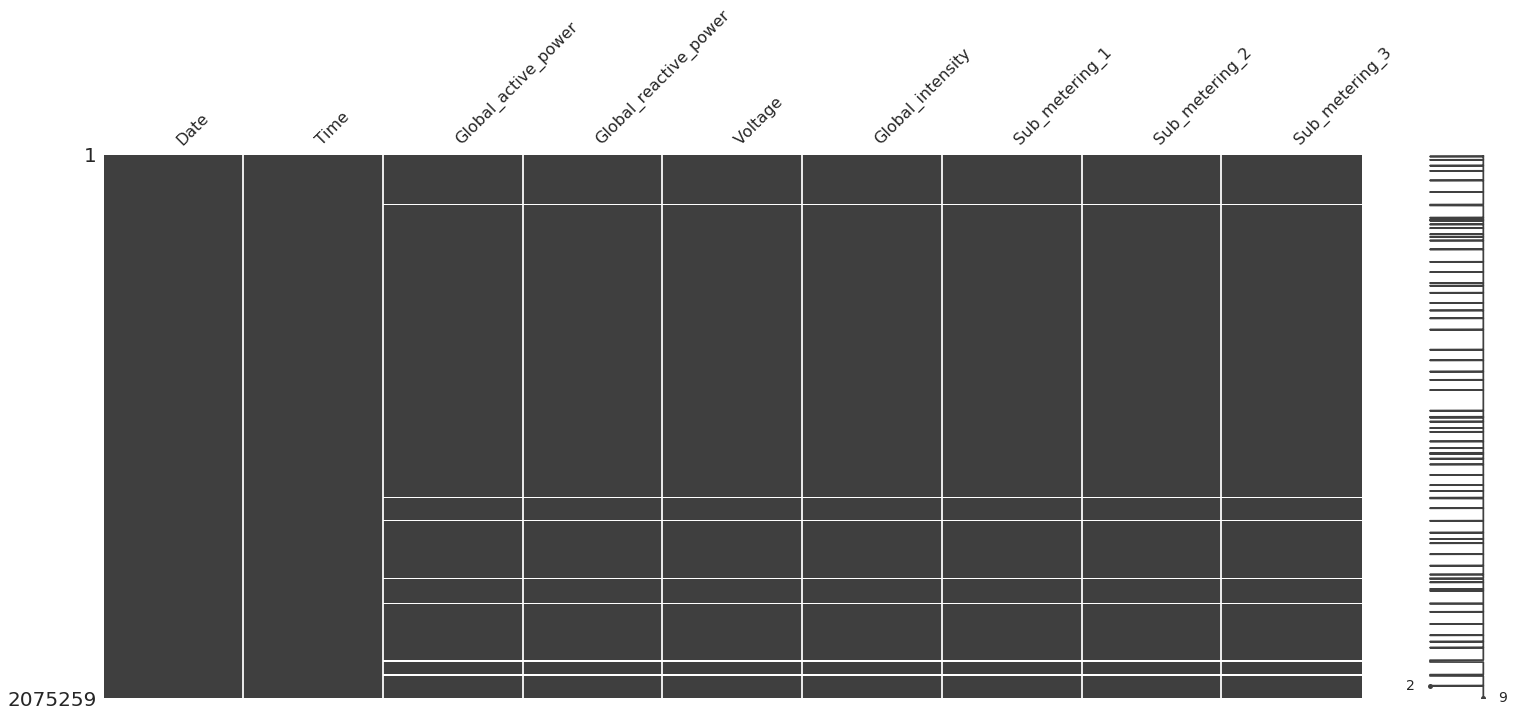

In [34]:
msno.matrix(dataset)

O gráfico acima representa a distribuição dos dados faltantes para cada coluna ou série temporal do dataset. O dataset pode conter diversas séries temporais, mas nesse caso vamos utilizar apenas um sinal, que corresponde à potência média por instante (minuto ou hora). As colunas restantes serão descartadas.

In [35]:
# Listar colunas que compõe o dataset
dataset.columns.values

array(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'], dtype=object)

In [36]:
# Remover colunas desnecessárias
COLUMNS_TO_DROP = ['Global_reactive_power',
                   'Voltage',
                   'Global_intensity',
                   'Sub_metering_1',
                   'Sub_metering_2',
                   'Sub_metering_3']

dataset = dataset.drop(columns=COLUMNS_TO_DROP)
dataset.head()

,Date,Time,Global_active_power
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


Configuração de colunas e criação de índice:

In [37]:
# Criar coluna 'datetime'
dataset['datetime'] = dataset['Date'] + ' ' + dataset['Time']

# Remover colunas desncessárias
dataset.drop(columns=['Date','Time'], inplace=True)

# Configurar o nome da série temporal
dataset.columns = ['global_active_power','datetime']

# Configurar índice do dataframe como o campo 'datetime'
dataset.set_index('datetime',inplace=True)
dataset.index = pd.to_datetime(dataset.index)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


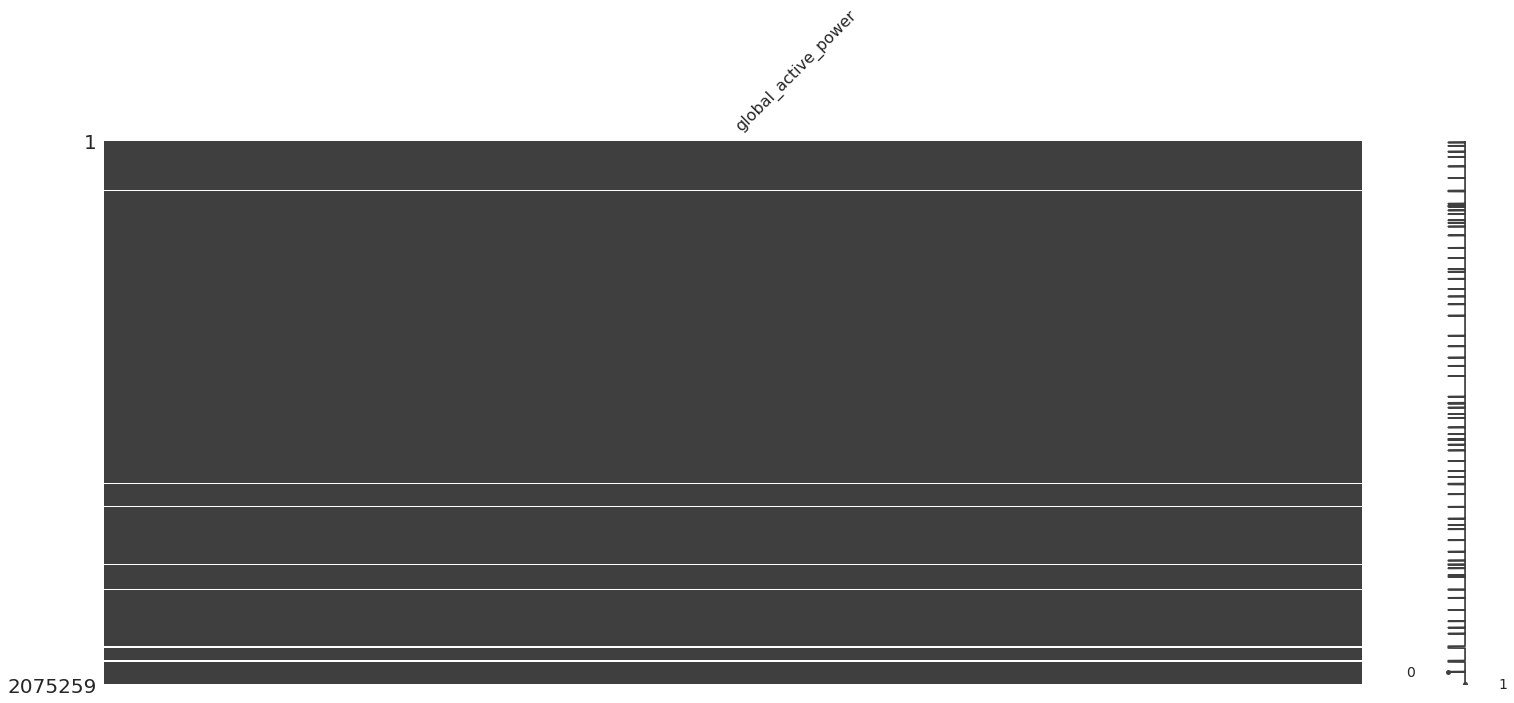

In [38]:
msno.matrix(dataset)

A função **fill_missing** definida a seguir recebe como parâmetros um *dataframe*, o número de períodos que define o intervalo de substituição e a coluna a qual se deseja reconstituir:

- **df** : *dataframe* do pandas contendo as séries temporais
- **periods** : número de períodos para usar como intervalo de substituição
- **column_number** : número da coluna para a qual se deseja reconstituir dados faltantes

Para maiores detalhes sobre o funcionamento dessa função, confira o arquivo utils.py.

In [39]:
from utils import fill_missing

# Executar função de reconstituição de dados

one_day = 24*60
one_week = 7*one_day

dataset = fill_missing(dataset,one_week,0)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Foram encontrados dados faltantes para 25979 instantes na coluna global_active_power.

Porcentagem de dados faltantes: 1.25 %.

1º iteração, ainda há 3 instantes com valores faltates.
2º iteração, ainda há 2 instantes com valores faltates.
3º iteração, ainda há 2 instantes com valores faltates.
4º iteração, ainda há 2 instantes com valores faltates.
Invertendo sentido de substituição...
5º iteração, ainda há 0 instantes com valores faltates.
Processo de reconstituição de dados faltantes concluído.


Finalmente é possível conferir o resultado obtido, plotanto novamente o dataset com a biblioteca **missingno**:

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


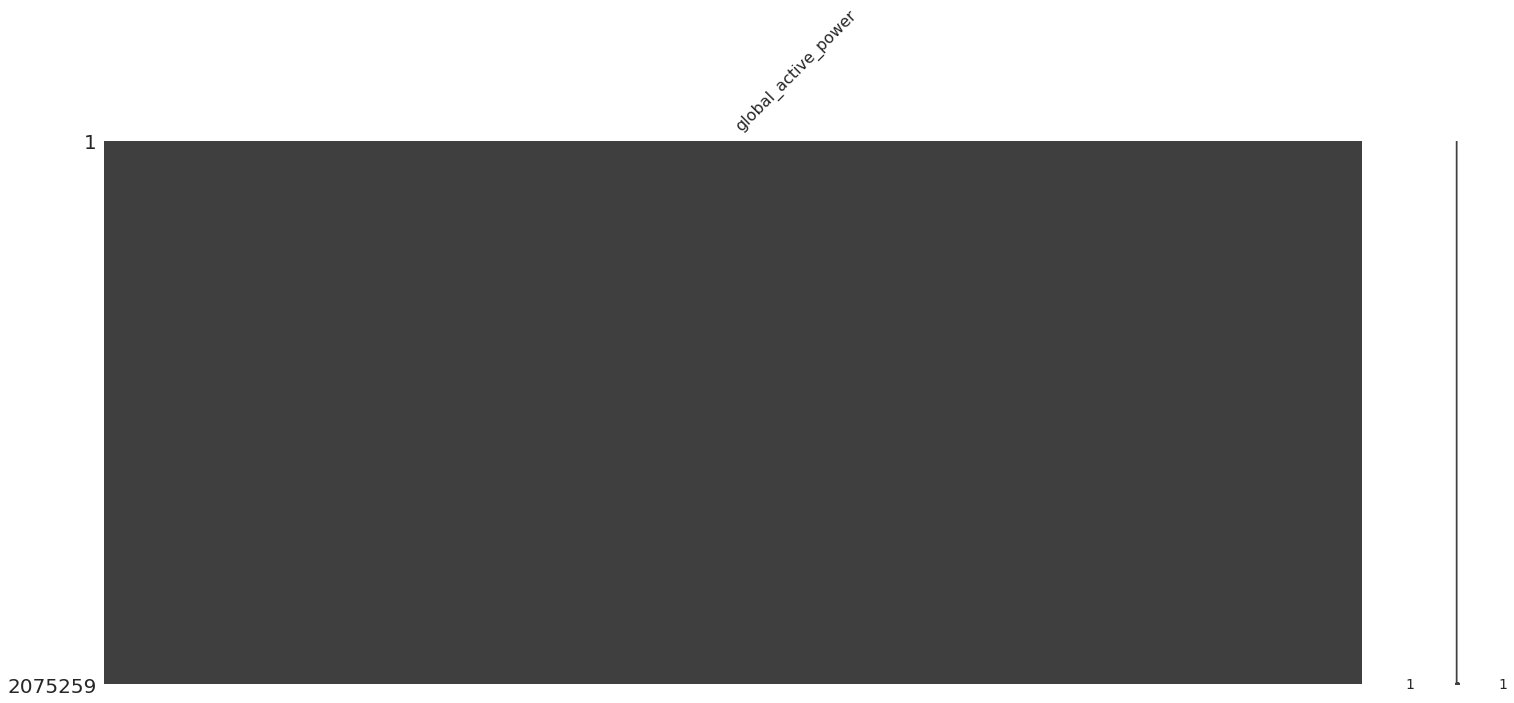

In [40]:
msno.matrix(dataset)

### 3.4 Reamostragem do dataset

A depender do horizonte para o qual se deseja fazer a previsão de carga, é necessário reamostrar o dataset para que o treinamento do modelo foque nos aspectos interessantes para a previsão. No caso de treinar o modelo para prever as horas seguintes, por exemplo, faz sentido reamostrar o dataset em horas.

In [44]:
dataset.set_index('datetime',inplace=True)
dataset.index = pd.to_datetime(dataset.index)

In [45]:
# Reamostrar o dataset em horas (H):
#
# No caso do dataset 'Individual household electric power consumption Data Set',
# os dados para a coluna 'Global_active_power' são dados em kW médio por minuto, 
# portanto caso seja desejada a reamostragem do dataset, deve-se utilizar a função
# 'mean()' para obter a média dos valores. A função a ser utilizada depende do dataset,
# sendo a escolha ideal uma particularidade de cada caso.

dataset = dataset.resample('H').mean()

# Finalmente revertemos o campo 'datetime' como coluna
dataset.reset_index(inplace=True)
dataset.head()

,datetime,global_active_power
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


Conferindo novamente a existência de dados faltantes

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


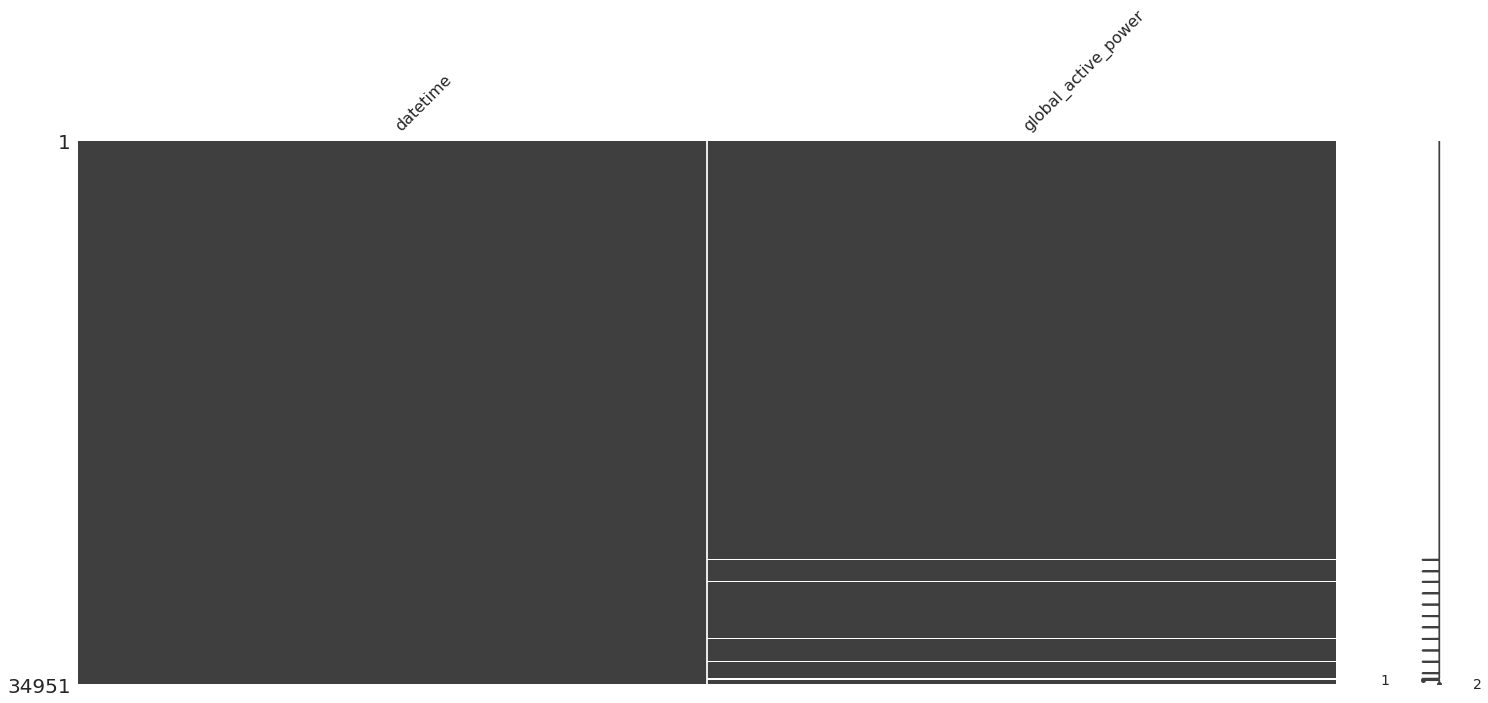

In [46]:
msno.matrix(dataset)

In [47]:
one_day = 24
one_week = 7*one_day

dataset = fill_missing(dataset,one_week,1)

Foram encontrados dados faltantes para 362 instantes na coluna global_active_power.

Porcentagem de dados faltantes: 1.04 %.

1º iteração, ainda há 0 instantes com valores faltates.
Invertendo sentido de substituição...
Processo de reconstituição de dados faltantes concluído.


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


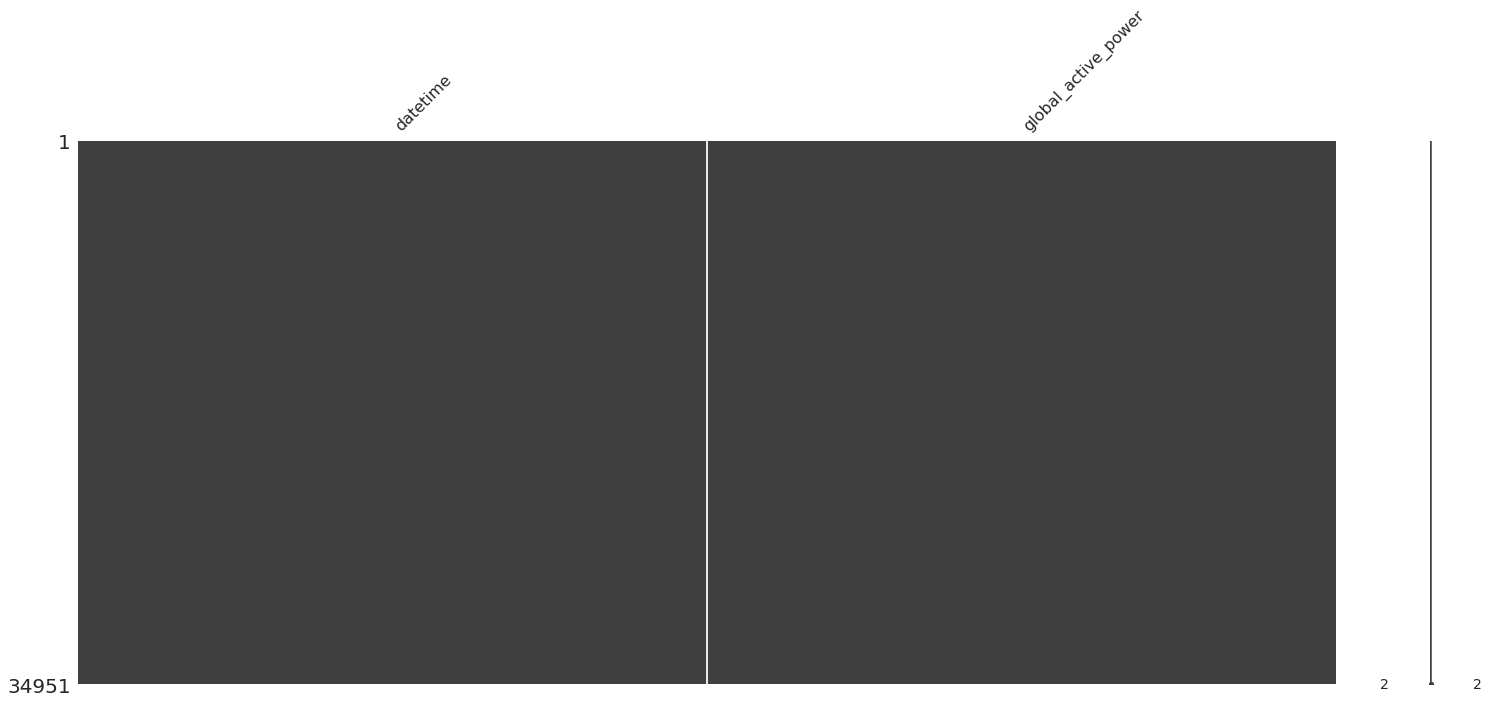

In [48]:
msno.matrix(dataset)

Finalmente, o dataset está livre de dados faltantes e pode ser salvo:

In [4]:
CLEANED_DATASET_NAME = 'hpc_m_clean'

In [50]:
dataset.to_csv(DATASET_FOLDER + CLEANED_DATASET_NAME + '.csv')

### 3.5 Criação de novas séries

Outras séries podem ser criadas a partir da original com intuido te favorecer o desempenho do modelo. No caso da previsão de carga, o que modelo realiza é a previsão da carga para o instante seguinte a partir do valor da potência média para o instante atual, no entanto podemos fornecer mais informações sobre o instante para o qual se deseja fazer a predição. No caso da previsão de carga, como o comportamento da demanda é sazonal e varia com a época do ano e o dia da semana, por exemplo, faz sentido fornecer ao modelo tais informações sobre o instante para o qual se deseja fazer a previsão. Nesse caso, criaremos as seguintes séries:

- **dayofyear_t+1** : dia do ano para o instante seguinte
- **weekofyear_t+1** : semana do ano para o instante seguinte
- **day_t+1** : dia do mês para o instante sequinte
- **dayofweek_t+1** : dia da semana para o instante seguinte
- **hour_t+1** : hora do dia para o instante seguinte


In [4]:
ls -l ./data/london_household_series/*h_clean.csv

-rw-r--r-- 1 root root 694458 Jun 16 20:13 ./data/london_household_series/MAC000017_h_clean.csv
-rw-r--r-- 1 root root 693389 Jun 16 20:14 ./data/london_household_series/MAC000024_h_clean.csv
-rw-r--r-- 1 root root 694107 Jun 16 20:15 ./data/london_household_series/MAC000247_h_clean.csv
-rw-r--r-- 1 root root 613973 Jun 16 20:16 ./data/london_household_series/MAC000315_h_clean.csv
-rw-r--r-- 1 root root 593633 Jun 16 20:17 ./data/london_household_series/MAC000520_h_clean.csv
-rw-r--r-- 1 root root 572970 Jun 16 20:18 ./data/london_household_series/MAC000836_h_clean.csv
-rw-r--r-- 1 root root 569970 Jun 16 20:19 ./data/london_household_series/MAC001267_h_clean.csv
-rw-r--r-- 1 root root 546223 Jun 16 20:20 ./data/london_household_series/MAC001563_h_clean.csv
-rw-r--r-- 1 root root 558918 Jun 16 20:21 ./data/london_household_series/MAC002749_h_clean.csv
-rw-r--r-- 1 root root 683889 Jun 16 20:21 ./data/london_household_series/MAC004583_h_clean.csv
-rw-r--r-- 1 root root 592481 Jun 16 20:

In [46]:
from datetime import timedelta

DATASET_FOLDER = '/content/datalab/energyforecast/data/london_household_series/'
CLEANED_DATASET_NAME = 'MAC004940_h_clean'

dataset = pd.read_csv(DATASET_FOLDER + CLEANED_DATASET_NAME + '.csv',
                      sep=",",
                      usecols=['datetime','kwh_per_half_hour'],
                      parse_dates=['datetime'])

dataset.columns = ['datetime','global_active_power']
dataset['dayofyear_t+1'] = dataset['datetime'].apply(lambda x: float((x + timedelta(minutes=1)).dayofyear ) )
dataset['weekofyear_t+1'] = dataset['datetime'].apply(lambda x: float((x + timedelta(minutes=1)).weekofyear ) )
dataset['day_t+1'] = dataset['datetime'].apply(lambda x: float((x + timedelta(minutes=1)).day ) )
dataset['dayofweek_t+1'] = dataset['datetime'].apply(lambda x: float((x + timedelta(minutes=1)).dayofweek) )
dataset['hour_t+1'] = dataset['datetime'].apply(lambda x: float((x + timedelta(minutes=1)).hour) )

print(dataset.shape)
dataset.head()

(18447, 7)


,datetime,global_active_power,dayofyear_t+1,weekofyear_t+1,day_t+1,dayofweek_t+1,hour_t+1
0,2012-01-21 10:00:00,0.405,21.0,3.0,21.0,5.0,10.0
1,2012-01-21 11:00:00,0.521,21.0,3.0,21.0,5.0,11.0
2,2012-01-21 12:00:00,2.660,21.0,3.0,21.0,5.0,12.0
3,2012-01-21 13:00:00,0.485,21.0,3.0,21.0,5.0,13.0
4,2012-01-21 14:00:00,0.390,21.0,3.0,21.0,5.0,14.0


### 4. Gerando o dataset

Após todas as etapas necessárias para processar os dados, vamos produzir os lotes de sequências necessários para o treinamento do modelo.

In [47]:
from utils import generate_datasets

# Vetor com pares de comprimento das sequênciass de entrada e saída [(n_input1,n_output1),(n_input2,n_output2) ... ]
INPUT_OUTPUT_VECTOR = [(60,60)]

# Vetor com valores para os tamanhos de lote [batch_size1, batch_size2, ...]
BATCH_SIZE_VECTOR = [500]

# Vetor de proporções para divisão do dataset em subdatasets [validation,train,test]
DATASET_SPLIT = [0.93,0.07,0.03]

# Caminho para o arquivo json contendo a lista de datasets gerados
DATASET_LIST_JSON_PATH = '/content/datalab/energyforecast/data/dataset_list.json'

# Padrão de nome para nomear os arquivos de lote
FILENAME_PATTERN = 'MAC004940_h'

# Utilizar dataset de validação amostrado no passado do dataset de treino
VALIDATION_FROM_PAST = False

# Diretório de saída
OUTPUT_FOLDER = '/content/datalab/energyforecast/data/sequences/'
os.environ['OUTPUT_FOLDER'] = OUTPUT_FOLDER

In [48]:
generate_datasets(df = dataset,
                  input_output_vector = INPUT_OUTPUT_VECTOR,
                  batch_size_vector = BATCH_SIZE_VECTOR,
                  dataset_split = DATASET_SPLIT,
                  dataset_list_json_path = DATASET_LIST_JSON_PATH,
                  filename_pattern = FILENAME_PATTERN,
                  output_folder = OUTPUT_FOLDER,
                  validation_from_past=VALIDATION_FROM_PAST)

Starting generation for dataset MAC004940_h_vf_60x60_500...

Started train dataset generation for column datetime
Started valid dataset generation for column datetime
Started test dataset generation for column datetime
Scaler model for column global_active_power dumped to /content/datalab/energyforecast/data/sequences/MAC004940_h_vf_60x60_500/scaler_global_active_power.save
Started train dataset generation for column global_active_power
Started valid dataset generation for column global_active_power
Started test dataset generation for column global_active_power
Scaler model for column dayofyear_t+1 dumped to /content/datalab/energyforecast/data/sequences/MAC004940_h_vf_60x60_500/scaler_dayofyear_t+1.save
Started train dataset generation for column dayofyear_t+1
Started valid dataset generation for column dayofyear_t+1
Started test dataset generation for column dayofyear_t+1
Scaler model for column weekofyear_t+1 dumped to /content/datalab/energyforecast/data/sequences/MAC004940_h_vf_60

Finalmente, os datasets gerados devem ser enviados para o Google Cloud Storage, de onde serão consumidos pelo modelo em treinamento.

In [5]:
# Diretório de saída
OUTPUT_FOLDER = '/content/datalab/energyforecast/data/sequences/'
os.environ['OUTPUT_FOLDER'] = OUTPUT_FOLDER

In [8]:
%bash
gsutil -m cp -r ${OUTPUT_FOLDER} gs://${BUCKET}/data

Copying file:///content/datalab/energyforecast/data/sequences/MAC000017_h_vf_60x60_500/MAC000017_h-global_active_power-train-0000000007.csv [Content-Type=text/csv]...
Copying file:///content/datalab/energyforecast/data/sequences/MAC000017_h_vf_60x60_500/MAC000017_h-hour_t+1-train-0000000006.csv [Content-Type=text/csv]...
Copying file:///content/datalab/energyforecast/data/sequences/MAC000017_h_vf_60x60_500/MAC000017_h-datetime-train-0000000034.csv [Content-Type=text/csv]...
Copying file:///content/datalab/energyforecast/data/sequences/MAC000017_h_vf_60x60_500/MAC000017_h-datetime-train-0000000021.csv [Content-Type=text/csv]...
Copying file:///content/datalab/energyforecast/data/sequences/MAC000017_h_vf_60x60_500/MAC000017_h-dayofyear_t+1-train-0000000018.csv [Content-Type=text/csv]...
Copying file:///content/datalab/energyforecast/data/sequences/MAC000017_h_vf_60x60_500/MAC000017_h-global_active_power-train-0000000028.csv [Content-Type=text/csv]...
Copying file:///content/datalab/energ